# Analiza danych przestrzennych z wykorzystaniem pakietów GeoPandas i PySAL

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

<AxesSubplot:>

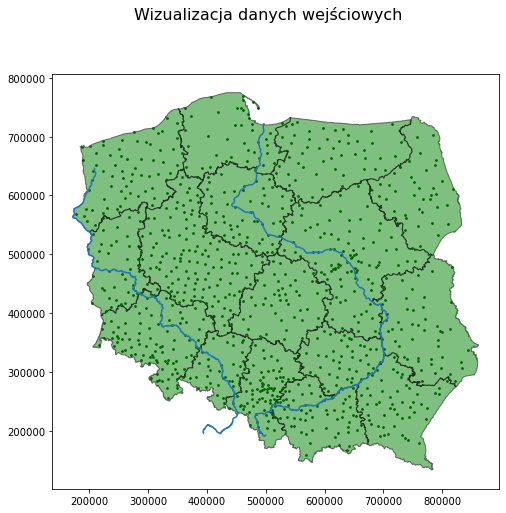

In [2]:
def homogeneous_poisson_on_rectangle(intensity, x_lim, y_lim):
    a = (abs(x_lim[1]-x_lim[0]))*(abs(y_lim[1]-y_lim[0]))
    ex = intensity*a
    n = np.random.poisson(lam=ex, size=1)
    nn=n[0]
    x=np.random.rand(nn)*(x_lim[1]-x_lim[0])+x_lim[0]
    y=np.random.rand(nn)*(y_lim[1]-y_lim[0])+y_lim[0]
    p={"X":x.flatten(),"Y":y.flatten()}
    points=pd.DataFrame(p)
    return points

wojewodztwa = gpd.read_file("Wojewodztwa.zip")
wojewodztwa = gpd.GeoDataFrame({"Nazwa":wojewodztwa["JPT_NAZWA_"], "geometry":wojewodztwa["geometry"]})

miejscowosci = gpd.read_file("Miejscowosci.zip")
miejscowosci = miejscowosci[miejscowosci["rodzaj"]=="miasto"]
miejscowosci = gpd.GeoDataFrame({"Nazwa":miejscowosci["nazwaGlown"], "geometry":miejscowosci["geometry"]})

rzeki = gpd.read_file("Rzeki.zip")
w = rzeki[rzeki["NAZ_RZEKI"]=="Wisła"]
o = rzeki[rzeki["NAZ_RZEKI"]=="Odra"]
n = pd.concat([o,w])
rzeki = gpd.GeoDataFrame({"Nazwa":n["NAZ_RZEKI"], "geometry":n["geometry"]})

wojewodztwa = wojewodztwa.to_crs(2180)
rzeki = rzeki.to_crs(2180)

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Wizualizacja danych wejściowych', fontsize=16)
wojewodztwa.plot(ax=ax, color="green", alpha=0.5,edgecolor="black")
rzeki.plot(ax=ax)
miejscowosci.plot(ax=ax, color="darkgreen", markersize=3)

Mierzenie długości, pola powierzchni i odległości 

Długość Wisły: 1019.76 km
Pole powierzchni Polski: 312506.64 km^2
Odległość Krakowa od Poznania: 334.6 km


<AxesSubplot:>

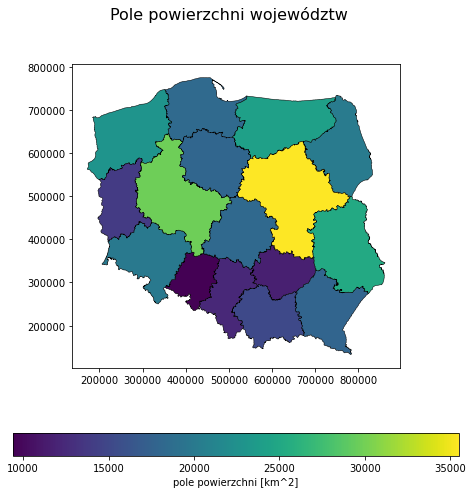

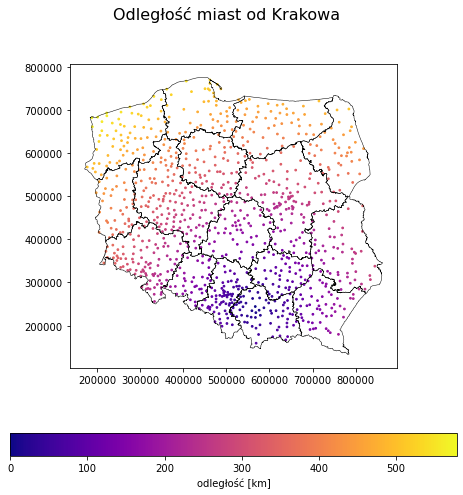

In [3]:
dlugosc_wisly = rzeki["geometry"][1].length/1000
print("Długość Wisły:",round(dlugosc_wisly,2),"km")

Pole=wojewodztwa["geometry"].area/1000/1000
p_p = np.sum(Pole)
pole=pd.DataFrame({"Pole":Pole})
print("Pole powierzchni Polski:",round(p_p,2),"km^2")

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Pole powierzchni województw', fontsize=16)
wojewodztwa.plot(Pole,ax=ax,legend=True,legend_kwds={'label': "pole powierzchni [km^2]",'orientation': "horizontal"},edgecolor="black",linewidth=0.5)

w_krak = miejscowosci[miejscowosci["Nazwa"]=="Kraków"]["geometry"].iloc[0]
odleglosc=pd.DataFrame({"Odległość od Krakowa":miejscowosci.distance(w_krak)/1000,"Nazwa":miejscowosci["Nazwa"]})
odl_krak_poz = odleglosc[odleglosc["Nazwa"]=="Poznań"]["Odległość od Krakowa"].iloc[0]
print("Odległość Krakowa od Poznania:",round(odl_krak_poz,2),"km")

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Odległość miast od Krakowa', fontsize=16)
wojewodztwa.boundary.plot(ax=ax, color="black",linewidth=0.5)
miejscowosci.plot(odleglosc["Odległość od Krakowa"],ax=ax,legend=True,legend_kwds={'label': "odległość [km]",'orientation': "horizontal"},markersize=3,cmap='plasma')


Wykorzystanie prostych operacji geometrycznych

148 miast leży bliżej niż 20 km od Wisły
Odra przepływa przez 5 województw


<AxesSubplot:>

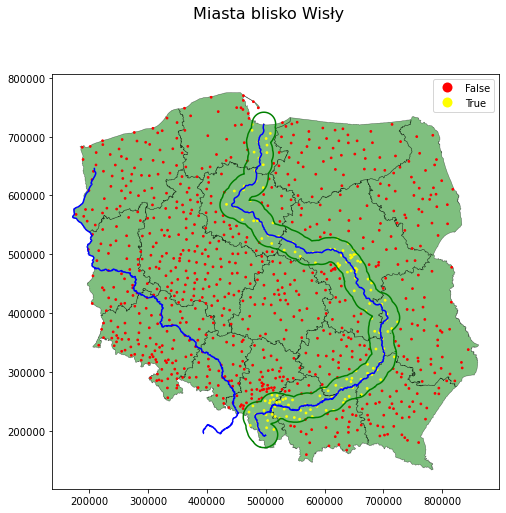

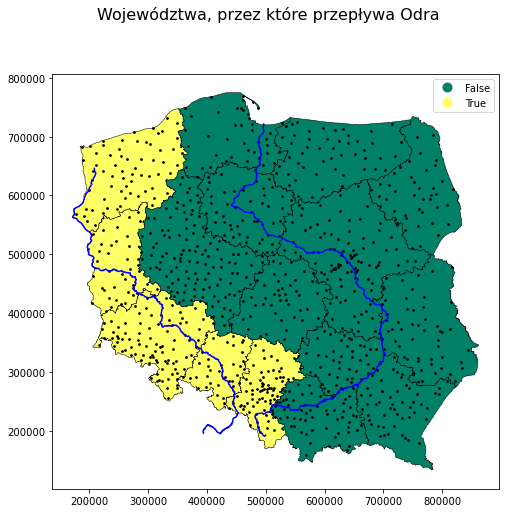

In [4]:
buffer=rzeki["geometry"][1].buffer(20000)
bw=miejscowosci.within(buffer)
ile=bw[bw==True].size
print(ile,"miast leży bliżej niż 20 km od Wisły")
blisko_wisly=pd.DataFrame({"Blisko Wisły":miejscowosci[bw]["Nazwa"]})

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Miasta blisko Wisły', fontsize=16)
wojewodztwa.plot(ax=ax, color="green", alpha=0.5,edgecolor="black",linewidth=0.5)
gpd.GeoSeries(buffer).boundary.plot(color="green",ax=ax)
rzeki.plot(color="blue",ax=ax)
miejscowosci.plot(bw,ax=ax,markersize=3,cmap='autumn',legend=True)

owo=wojewodztwa.intersects(rzeki["geometry"][0])
ile=owo[owo==True].size
print("Odra przepływa przez",ile,"województw")
odr=pd.DataFrame({"Odra w obrębie":wojewodztwa[owo]["Nazwa"]})

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Województwa, przez które przepływa Odra', fontsize=16)
wojewodztwa.plot(owo,ax=ax,legend=True,cmap="summer",edgecolor="black",linewidth=0.5)
miejscowosci.plot(ax=ax, color="black",markersize=3)
rzeki.plot(color="blue",ax=ax)

Generowanie procesu punktowego w obrębie poligonu

<AxesSubplot:>

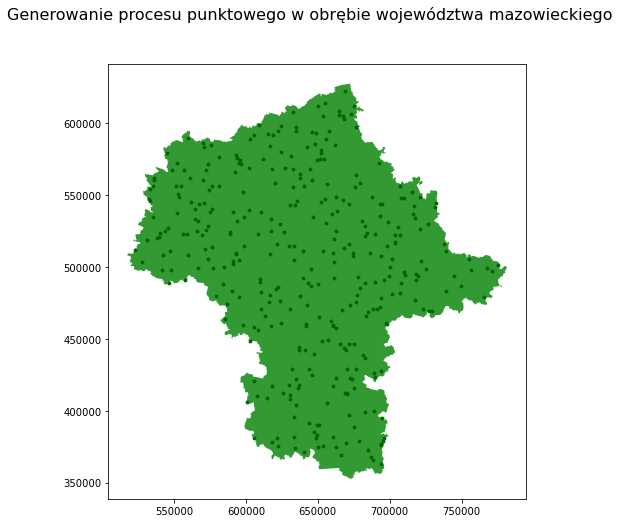

In [5]:
def homogeneous_poisson_on_polygon(intensity, polygon):
    """
    Parameters
    -------
    intensity: float
        Liczba dodatnia określająca intensywność procesu punktowego.
    polygon: Polygon
        Obszar, na którym mają zostać wygenerowane punkty.
    
    Returns
    -------
    points: GeoDataFrame
        Tablica zawierająca kolumnę "geometry" ze współrzędnymi punktów w odwzorowaniu kartograficznym identycznym jak odwzorowanie zmiennej polygon.
    """
    polygon = polygon.to_crs(2180)
    pros=polygon.bounds
    points=homogeneous_poisson_on_rectangle(intensity, [pros["minx"].iloc[0],pros["maxx"].iloc[0]], [pros["miny"].iloc[0],pros["maxy"].iloc[0]])
    s=gpd.GeoSeries.from_xy(points["X"],points["Y"]).set_crs(2180)
    points=s.within(polygon.iloc[0])
    return gpd.GeoDataFrame({"geometry":s[points==True]})

points=homogeneous_poisson_on_polygon(10**(-8), wojewodztwa[wojewodztwa["Nazwa"]=="mazowieckie"]["geometry"])

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Generowanie procesu punktowego w obrębie województwa mazowieckiego', fontsize=16)
wojewodztwa[wojewodztwa["Nazwa"]=="mazowieckie"].plot(ax=ax, color="green",alpha=0.8)
points.plot(ax=ax,color="darkgreen", markersize=8)